
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
#from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import args
from dataset import *
from models import *
from train import *
from fairness_metrics import *

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


# Preparing the dataset

In [2]:
data_dir = './../data/bids_with_sensitive_recordings/'
target_diagnosis = 'voc_fold_paralysis'
dataset = VBAIDataset(data_dir)
person_session_pairs = get_person_session_pairs(dataset)

model_to_test = 'test_5'
model_dir = os.path.join('./..', 'saved_models', model_to_test)
test_identities = np.load(os.path.join(model_dir, 'test_ids.npy'))

test_dataset = MyAudioDataset(test_identities,dataset,person_session_pairs,diagnosis_column=target_diagnosis,algo='DL')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

#test_data_labels = np.load(os.path.join(model_dir, 'test_gt_pred.npy'))
#test_gts = test_data_labels[0]
#model_preds = test_data_labels[1] 
# this might not be the predictions from the best models.
# check the tensorboard logs to find out the best model weights

print("Test data size : ", len(test_dataset))

test_dataset.set_algorithm_type('DT')
opensmile_df_test,feature_cols,label_cols = create_open_smile_df(test_dataset,include_GAS=True,diagnosis_column=target_diagnosis)
test_dataset.set_algorithm_type('DL')

Test data size :  449


In [3]:
best_model_weight = 'best_model_epoch_66.pth'
model = get_models(args=None)
model.load_state_dict(torch.load(os.path.join(model_dir, best_model_weight)))
binary_crs_entropy_ls = torch.nn.BCELoss(reduction='none')

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = model.to(device)

model.eval()
with torch.no_grad():
    test_ls,test_acc,model_preds,ground_truths = train_epoch(model = model, epoch = 0, mode = "Test", data_loader = test_loader, device = device,
                                                             loss_func = binary_crs_entropy_ls, optimizer = None, scheduler = None, writer = None)


Epoch 0,Test: 100%|███████████████████████████████████| 4/4 [00:01<00:00,  3.80batch/s, Acc=0.85, Lss=0.43]


--- GENDER ---
                         TP   FP    FN     TN       TPR  FPR
Female gender identity  2.0  0.0  28.0  263.0  0.066667  0.0
Male gender identity    0.0  0.0  38.0  118.0  0.000000  0.0


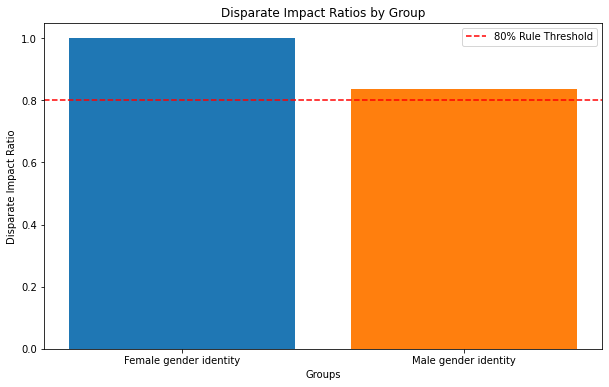

Disparate Impact Ratio for Group Female gender identity: 1.0
Disparate Impact Ratio for Group Male gender identity: 0.8363328495403967


--- GENDER ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514



In [4]:
_, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None,calc_chi_square=False)
print(_print_string_)
print()
equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None)

--- SITE ---
            TP   FP    FN     TN       TPR  FPR
MIT        0.0  0.0   0.0   90.0       NaN  0.0
VUMC       2.0  0.0  66.0   96.0  0.029412  0.0
USF        0.0  0.0   0.0  121.0       NaN  0.0
Mt. Sinai  0.0  0.0   0.0   74.0       NaN  0.0


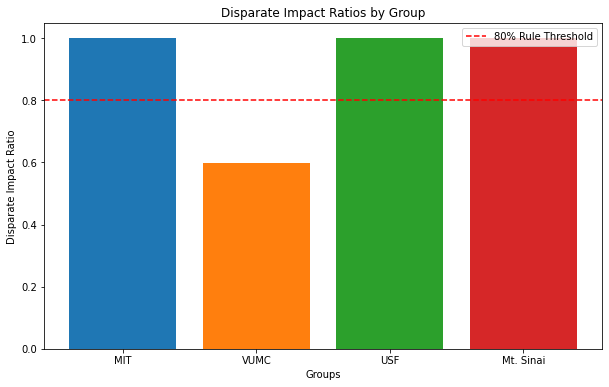

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group VUMC: 0.5975609756097561
Disparate Impact Ratio for Group USF: 1.0
Disparate Impact Ratio for Group Mt. Sinai: 1.0


--- SITE ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  NaN
   3.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0 

In [6]:
_, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)
print(_print_string_)
print()
equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)

--- AGE ---
         TP   FP    FN     TN       TPR  FPR
21-40   2.0  0.0  28.0  126.0  0.066667  0.0
41-60   0.0  0.0  38.0  117.0  0.000000  0.0
81-100  0.0  0.0   0.0   71.0       NaN  0.0
61-80   0.0  0.0   0.0   67.0       NaN  0.0


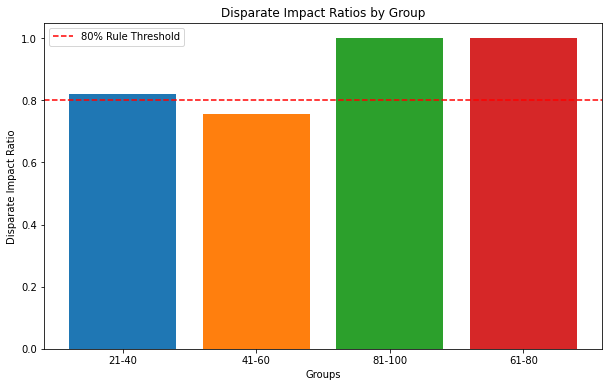

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group 21-40: 0.8205128205128205
Disparate Impact Ratio for Group 41-60: 0.7548387096774194
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 61-80: 1.0


--- AGE_BIN ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0  0.0    NaN
   4.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   1.0  0.0  0.0
   2.0  0.0  0.0
   3.0  0.0  NaN
   4.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0

In [7]:
_, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='age',writer=None)
print(_print_string_)
print()
equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='AGE_bin',writer=None)

In [ ]:
def create_open_smile_df(audio_dataset, include_GAS = True, diagnosis_column = 'voc_fold_paralysis'):
    # Extract opensmile features, age, gender, and site
    opensmile_features = []
    ages = []
    genders = []
    sites = []
    GENDERS_org = []
    SITES_org = []
    AGE_binned = []
    diagnosis = []

    for i in range(len(audio_dataset)):
        feature, age, gender, site, binned_age, diagnosis_label = audio_dataset[i]
        opensmile_feature = feature['opensmile']
        opensmile_features.append(opensmile_feature.squeeze())
        ages.append(age)
        genders.append(gender)
        sites.append(site)
        GENDERS_org.append(audio_dataset.map_gender_back(gender))
        SITES_org.append(audio_dataset.map_site_back(site))
        AGE_binned.append(binned_age)
        diagnosis.append(diagnosis_label)
    
    # Convert to DataFrame
    opensmile_df = pd.DataFrame(opensmile_features)
    opensmile_df['age'] = ages
    opensmile_df['gender'] = genders
    opensmile_df['site'] = sites
    opensmile_df['GENDER_org'] = GENDERS_org
    opensmile_df['SITE_org'] = SITES_org
    opensmile_df['AGE_bin'] = AGE_binned
    opensmile_df[diagnosis_column] = diagnosis
    
    
    # Standardize the opensmile features
    if include_GAS:
        feature_columns = opensmile_df.columns[:-4]
        label_columns = opensmile_df.columns[-4:]
    
    else:
        feature_columns = opensmile_df.columns[:-7]
        label_columns = opensmile_df.columns[-7:]
    
    return opensmile_df, feature_columns, label_columns

## Defining Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

def RF_classifier(train_dataset, include_GAS = True, target_column = 'voc_fold_paralysis'):
    
    opensmile_df_train, feature_columns_train , _ = create_open_smile_df(train_dataset, include_GAS=include_GAS,
                                                                         diagnosis_column = target_column)

    scalar = StandardScaler()
    X_train = scalar.fit_transform(opensmile_df_train[feature_columns_train])
    y_train = opensmile_df_train[target_column] 
    
    #Train a RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    
    return clf, scalar


## Including Gender, Age, Site as feature

In [ ]:
# age, gender, site, vocal_fold_paralysis
target_diagnosis = 'voc_fold_paralysis'
RF_clf, scalar = RF_classifier(train_dataset, include_GAS=True, target_column = target_diagnosis)

# Creating test data for generating prediction using RF classifier.
# An training_dataset instance needs to be passed so that the same transformations are used.

opensmile_df_test, feature_columns , label_columns = create_open_smile_df(DT_test_dataset,include_GAS=True,
                                                                          diagnosis_column = target_diagnosis)
X_test = scalar.transform(opensmile_df_test[feature_columns])
y_test = opensmile_df_test[target_diagnosis]
predictions = RF_clf.predict(X_test)

print(label_columns)

### Feature importance (including GAS)

In [ ]:
# Get feature importances
feature_importances = RF_clf.feature_importances_
#print(feature_importances.shape)
#print(len(feature_columns))
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

### Different Fairness Metrics

In [ ]:
# contingency_table = pd.crosstab(sensitive_attribute, _predictions_, rownames=[attribute], colnames=['Prediction'])

    # print(contingency_table)
    
    # # Compare distributions
    # _print_string_ = f'---{attribute.upper()}---\n'
    # if calc_chi_square:
    #     chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    #     chi_square_result = {
    #         "chi2_stat": chi2_stat,
    #         "p_value": p_value,
    #         "dof": dof,
    #         "expected": expected
    #     }
    #     #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
    #     _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'


    # contingency_table = pd.DataFrame({
    #     'Group': [map_func(group) for group in unique_groups],
    #     'DIR': [disparate_impact_ratios[group] for group in unique_groups]
    # }).set_index('Group')
    
    # print(contingency_table)
    #accuracies = pd.Series(accuracies)


In [ ]:

# https://towardsdatascience.com/mitigating-bias-in-ai-with-aif360-b4305d1f88a9
# https://aif360.readthedocs.io/en/stable/modules/generated/aif360.sklearn.metrics.disparate_impact_ratio.html

from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from fairness import tools, balancers

_gender_mapping_ = {
    'Male gender identity': 0,
    'Female gender identity': 1,
    'no record': 2,
    'Non-binary or genderqueer gender identity': 3
}

_site_mapping_ = {
    'Mt. Sinai': 0, 
    'VUMC': 1,
    'MIT': 2,
    'USF': 3,
    'WCM': 4
}

_age_mapping_ = {
    '0-20': 0,
    '21-40': 1,
    '41-60': 2,
    '61-80': 3,
    '81-100': 4
}

def chi_DIR_plot(dataset, _opensmile_df_, ground_truth, _predictions_, attribute='gender', calc_chi_square=True):
    
    print("---" , attribute.upper(), "---")
    #_print_string_ = f'---{attribute.upper()}---\n'
    _print_string_ = ''
    sensitive_attribute = _opensmile_df_[attribute]
    if attribute == 'age':
        sensitive_attribute = _opensmile_df_['AGE_bin']
        
    #accuracies = [_predictions_ == ground_truth]
    accuracies = np.array(_predictions_) == np.array(ground_truth)
    
    unique_groups = sensitive_attribute.unique()
    favorable_outcome = {}

    def age_map(x):
        labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
        return labels[x]

    if attribute == 'gender':
        map_func = dataset.map_gender_back
    elif attribute == 'site':
        map_func = dataset.map_site_back
    elif attribute == 'age':
        map_func = age_map
        
    tpr_fpr_data = {}
    for group in unique_groups:
        #group_predictions = _predictions_[sensitive_attribute == group]
        group_predictions = accuracies[sensitive_attribute == group]
        group_truth = ground_truth[sensitive_attribute == group]
        
        tp = np.sum((group_predictions == 1) & (group_truth == 1)) #+ 0.001
        fp = np.sum((group_predictions == 1) & (group_truth == 0)) #+ 0.001
        fn = np.sum((group_predictions == 0) & (group_truth == 1)) #+ 0.001
        tn = np.sum((group_predictions == 0) & (group_truth == 0)) #+ 0.001

        tpr = tp / (tp + fn)  # True Positive Rate
        fpr = fp / (fp + tn)  # False Positive Rate

        tpr_fpr_data[group] = {
            'TP': tp,
            'FP': fp,
            'tn': tn,
            'fn': fn,
            'tpr': tpr,
            'fpr:': fpr
        }
        favorable_outcome[group] = np.mean(group_predictions)
        #favorable_outcome[group] = np.mean(group_predictions == group_truth)
        
    most_favorable_group = max(favorable_outcome, key=favorable_outcome.get)
    disparate_impact_ratios = {group: favorable_outcome[group] / favorable_outcome[most_favorable_group] for group in unique_groups}

    # accuracy_data = {
    #     group: {
    #         'correct': np.sum(accuracies[sensitive_attribute == group]),
    #         'incorrect': np.sum(~accuracies[sensitive_attribute == group])
    #     }
    #     for group in unique_groups
    # }

    contingency_table = pd.DataFrame(tpr_fpr_data).T
    contingency_table.index = [map_func(group) for group in contingency_table.index]

    print(contingency_table)

    if calc_chi_square:
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
        chi_square_result = {
            "chi2_stat": chi2_stat,
            "p_value": p_value,
            "dof": dof,
            "expected": expected
        }
        #print(f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}')
        _print_string_ += f'Chi-Square Statistic: {chi2_stat}, p-value: {p_value}\n'
        
        if p_value <= 0.05:
            _print_string_ += 'Prediction accuracy is Dependent\n'
        else:
            _print_string_ += 'Prediction accuracy is Independent \n'
    
    #Print the disparate impact ratios
    for group, ratio in disparate_impact_ratios.items():
        _print_string_ += f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}\n'
        #print(f'Disparate Impact Ratio for Group {map_func(group)}: {ratio}')

    # Plotting the disparate impact ratios
    plt.figure(figsize=(10, 6))
    groups = [map_func(group) for group in unique_groups]
    ratios = [disparate_impact_ratios[group] for group in unique_groups]
    plt.bar(groups, ratios, color=plt.get_cmap('tab10').colors[:len(unique_groups)])
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Rule Threshold')
    plt.xlabel('Groups')
    plt.ylabel('Disparate Impact Ratio')
    plt.title('Disparate Impact Ratios by Group')
    plt.legend()
    plt.show()

    return chi_square_result, disparate_impact_ratios, _print_string_

# Scott Lee, “scotthlee/fairness: First release!”. Zenodo, Jun. 01, 2021. doi: 10.5281/zenodo.4890946.
# https://github.com/scotthlee/fairness/tree/master?tab=readme-ov-file

# https://developers.google.com/machine-learning/glossary/fairness#s
# https://pubs.rsna.org/page/ai/blog/2023/08/ryai_editorsblog082523

# https://github.com/gpleiss/equalized_odds_and_calibration

# def reload_fairness_modules():
#     importlib.reload(tools)
#     importlib.reload(balancers)

def equalized_metrics(_opensmile_df_, y_gt, y_pred, attribute='gender'):
    #reload_fairness_modules()
    print("---" , attribute.upper(), "---")
    sensitive_attribute = _opensmile_df_[attribute]
    pred_stats = tools.clf_metrics(y_gt, y_pred)
    print(pred_stats)
    
    pb = balancers.BinaryBalancer(y=y_gt, y_=y_pred, a=sensitive_attribute, summary=False)
    print("\nEqualized ODDs")
    pb.adjust(goal='odds', summary=False)
    pb.summary()
    #pb.plot(xlim=(0, 0), ylim=(0, 0), lp_lines=False, roc_curves=False)

    print("Equal Opportunity")
    pb.adjust(goal='opportunity', summary=False)
    pb.summary()
    #pb.plot(xlim=(0, 0), ylim=(0, 0), lp_lines=False, roc_curves=False)


In [ ]:
# _, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
# print(print_str)
# #print()

# #equalized_metrics(opensmile_df_test, y_test, predictions, attribute='gender')
# #print()

# _, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')
# print(print_str)
# print()


# _, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
# print(print_str)
# print()


#### Gender fairness

In [ ]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='gender')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='gender')
print()

#### Age fairness

In [ ]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='age')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='AGE_bin')
print()

#### Site fairness

In [ ]:
_, _ , print_str = chi_DIR_plot(DT_test_dataset, opensmile_df_test, y_test, predictions, attribute='site')
print(print_str)
print()

equalized_metrics(opensmile_df_test, y_test, predictions, attribute='site')
print()

In [ ]:
# # https://www.sciencedirect.com/science/article/pii/S0169260721006581#fig0003
# # https://datascientest.com/en/shap-what-is-it
# # https://shap.readthedocs.io/en/latest/
# #https://github.com/shap/shap#citations

# import shap

# explainer = shap.TreeExplainer(RF_clf)
# shap_values = explainer.shap_values(X_test)

# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test, feature_names=feature_columns)
# #shap.force_plot(shap_values, X_test)

In [ ]:

#prepare the data for plotting 2D scatter plot of PCA features
pca_df = pd.DataFrame(pca_result[:,:3], columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
#coolwarm, plasma, viridis
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['GENDER_org'].astype('category').cat.codes, cmap='plasma')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Gender")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()



In [ ]:

#Plot PCA 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA Result with 3 Components')
plt.show()

In [ ]:

#prepare the data for plotting 2D scatter plot of PCA features
tsne_df = pd.DataFrame(tsne_result[:,:3], columns=['TSNE1', 'TSNE2', 'TSNE3'])
tsne_df = pd.concat([tsne_df, opensmile_df[['age', 'GENDER_org', 'SITE_org']].reset_index(drop=True)], axis=1)

#Plot TSNE 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], tsne_df['TSNE3'], c=tsne_df['age'].astype('category').cat.codes, cmap='viridis')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Age")
ax.add_artist(legend1)

# Add labels
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_zlabel('TSNE3')
plt.title('TSNE Result with 3 Components')
plt.show()